In [1]:
%matplotlib notebook

# Specify CUDA device
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = 'gpu'

from jax import jit, config, grad
config.update("jax_enable_x64", True)

# Check we're running on GPU
# from jax.lib import xla_bridge
# print(xla_bridge.get_backend().platform)

import time
import numpy as np
import jax.numpy as jnp
import optax
import jaxopt

from matplotlib import pyplot as plt
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Synthesis_lib as synlib
#import scatcovjax.Fast_scattering_lib as scatlib
import scatcovjax.Scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

import scatcovjax.plotting as plot
plot.notebook_plot_format()

In [2]:
import jax
# Check we're running on GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Loss function

In [3]:
@jit
def loss_func(flm_float):
    # Make complex flm
    flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scatlib.scat_cov_dir(flm, L, N, J_min, sampling,
                                                                        None, reality, multiresolution,
                                                                        for_synthesis=True,
                                                                        normalisation=tP00_norm, filters=filters,
                                                                        quads=weights, precomps=precomps)
    # Control for mean + var
    loss = synlib.chi2(tmean, mean_new)
    loss += synlib.chi2(tvar, var_new)

    # Add S1, P00, C01, C11 losses
    loss += synlib.chi2(tS1, S1_new)
    loss += synlib.chi2(tP00, P00_new)
    loss += synlib.chi2(tC01, C01_new)
    loss += synlib.chi2(tC11, C11_new)

    return loss

In [44]:
sampling = "mw"
multiresolution = True
reality = True
N = 2
J_min = 2
niter = 300
repo = '/travail/lmousset/CosmoGrid/CosmoFiducial_barionified_nside512/'

L_limite = 256 # L limite until which we use fast computation

for i, L in enumerate([256]):
    print(f'\n {L=}')
    J_max = s2wav.utils.shapes.j_max(L)
    J = J_max - J_min + 1
    print(f'{J=} {J_max=}')
    
    if L <= L_limite:
        print('Using Fast Scattering lib')
        import scatcovjax.Fast_scattering_lib as scatlib
    else:
        print('Using Old Scattering lib')
        import scatcovjax.Scattering_lib as scatlib
    
    ### Quadrature Weights
    weights = scatlib.quadrature(L, J_min, sampling, None, multiresolution) 
    
    ### Precomp
    if L <= L_limite:
        print('Full precomputation')
        precomps = scatlib.generate_full_precompute(L=L,
                                                    N=N,
                                                    J_min=J_min,
                                                    sampling=sampling,
                                                    reality=reality,
                                                    multiresolution=multiresolution,
                                                    nside=None)
    else:
        print('Soft precomputation')
        precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L=L, 
                                                                             N=N, 
                                                                             J_min=J_min, 
                                                                             lam=2.0, 
                                                                             sampling=sampling, 
                                                                             nside=None, 
                                                                             forward=False,
                                                                             reality=reality, 
                                                                             multiresolution=multiresolution)
    
    ### Filters
    filters = filters_directional_vectorised(L, N, J_min)
    filters = filters[0]
    
    ### Sky
    f_target, flm_target = sphlib.make_CosmoGrid_sky(L, dirmap=repo, run=0, idx_z=10, sampling=sampling, 
                                       nest=False, normalize=True, reality=reality)
    print('Target = LSS map')

    ### Power spectrum of the target
    ps_target = sphlib.compute_ps(flm_target)

    ### P00 for normalisation
    #print(flm_target.shape, filters.shape, precomps[0][-1].shape)
    tP00_norm = scatlib.get_P00only(flm_target, L, N, J_min, sampling, None,
                                    reality, multiresolution, for_synthesis=False, normalisation=None,
                                    filters=filters, quads=weights, precomps=precomps)  # [J][Norient]

    ### Scat coeffs S1, P00, C01, C11
    # P00 is one because of the normalisation
    tcoeffs = scatlib.scat_cov_dir(flm_target, L, N, J_min, sampling, None,
                           reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                           filters=filters, quads=weights, precomps=precomps)

    tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs  # 1D arrays
    
    ### Initial condition
    if i == 0:
        print('Starting from white noise')
        # Gaussian white noise in pixel space with the variance of the target
        print(f'{tvar=}')
        np.random.seed(42)
        if reality:  # Real map
            f = np.sqrt(tvar) * np.random.randn(L, 2 * L - 1).astype(np.float64)
        else:
            f = np.sqrt(tvar) * np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j * np.random.randn(L, 2 * L - 1).astype(np.float64)

        flm = s2fft.forward_jax(f, L, reality=reality)

        # Cut the flm
        flm = flm[:, L - 1:] if reality else flm
        flm_start = jnp.copy(flm)  # Save the start point as we will iterate on flm
        flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)]) # [2, L, L]  
        
    else:
        print('Starting from previous synthesis result')
        flm_float = np.zeros((2, L, L))
        # Fill the array with previous result
        flm_float[:, :L//2, :L//2] = flm_temp
        #plt.matshow(flm_float[0, :, :])
        #plt.matshow(flm_float[1, :, :])
        # Get the indices where we want to put random noise
        l, m = np.where((np.real(flm_target).T + flm_float[0, :, :])==0)  
        # Compute the STD on the target flm 
        std_flm_target_real = np.std(np.real(flm_target)[l, m])
        std_flm_target_imag = np.std(np.imag(flm_target)[l, m])
        # Fill the start 
        flm_float[0, l, m] = std_flm_target_real * np.random.randn(L, L).astype(np.float64)[l, m]
        flm_float[1, l, m] = std_flm_target_imag * np.random.randn(L, L).astype(np.float64)[l, m]
        
        #plt.matshow(flm_float[0, :, :])
        #plt.matshow(flm_float[1, :, :])
         
    ### Run the synthesis on all coeffs
    if i == 0:
        loss_history = None
    else:
        loss_history = loss_history
    flm_temp, loss_history = synlib.fit_jaxopt_Scipy(flm_float, loss_func, method='L-BFGS-B', 
                                                     niter=niter, loss_history=loss_history)


### Store the flm
flm_end = flm_temp[0, :, :] + 1j * flm_temp[1, :, :]


 L=256
J=7 J_max=8
Using Fast Scattering lib
Full precomputation
Map at redshift z=0.14677950739860535
Mean and STD: -0.000 and 1.000
Mean and STD: 0.050 and 0.910
Target = LSS map
Starting from white noise
tvar=Array(0.80445943+0.j, dtype=complex128)


2023-11-16 16:43:06.367280: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_loss_func] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-11-16 16:48:08.834022: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 7m2.462897758s

********************************
[Compiling module jit_loss_func] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Iter 0, Success: False, Loss = 35.10407827216933, Time = 619.8769035339 s/iter
Iter 10, Success: False, Loss = 10.121634619668784, Time = 5.4770739079 s/iter
Iter 20, Success: False, Loss = 6.5629407892351015, Time = 4.4342293739 s/iter
Iter 30, Success: False, Loss = 4.954287146953231, Time = 4.6223394871 s/iter
Iter 40, Success: False, Loss = 3.0878682339071335, Time = 4.4314498901 s/iter
Iter 50, Success: False, Loss = 2.2140336413785278, Time = 4.4922132492 s/iter
Iter 60, Success: False, Loss = 1.37627665726956, Time = 4.4690635204 s/iter
Iter 70, Success: False, Loss = 1.0628929548762058, Time = 4.5320644379 s/iter
Iter 80, Success: False, Loss = 0.6166596995612785, Time = 4.4473991394 s/iter
Iter 90, Success: False, Loss = 0.2535347370489316, Time = 4.4729707241 s/iter
Iter 100, Success: False, Loss = 0.20197450542240908, Time = 4.4572389126 s/iter
Iter 110, Success: False, Loss = 0.0771324578967097, Time = 4.4485800266 s/iter
Iter 120, Success: False, Loss = 0.07121091224805232

# Check the synthesis

In [45]:
# Coeffs
#scoeffs = scatlib.scat_cov_dir(flm_start, L, N, J_min, sampling, None,
 #                          reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
  #                         filters=filters, quads=weights, precomps=precomps)
ecoeffs = scatlib.scat_cov_dir(flm_end, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                       filters=filters, quads=weights, precomps=precomps)


tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs
#smean, svar, sS1, sP00, sC01, sC11 = scoeffs
emean, evar, eS1, eP00, eC01, eC11 = ecoeffs

In [46]:
### Cut the flm that are not contrained
flm_target = flm_target.at[0: 2**J_min + 1, :].set(0. + 0.j)

In [47]:
# Make the maps
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
#f_start = s2fft.inverse_jax(flm_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_end, L, reality=reality)

<IPython.core.display.Javascript object>


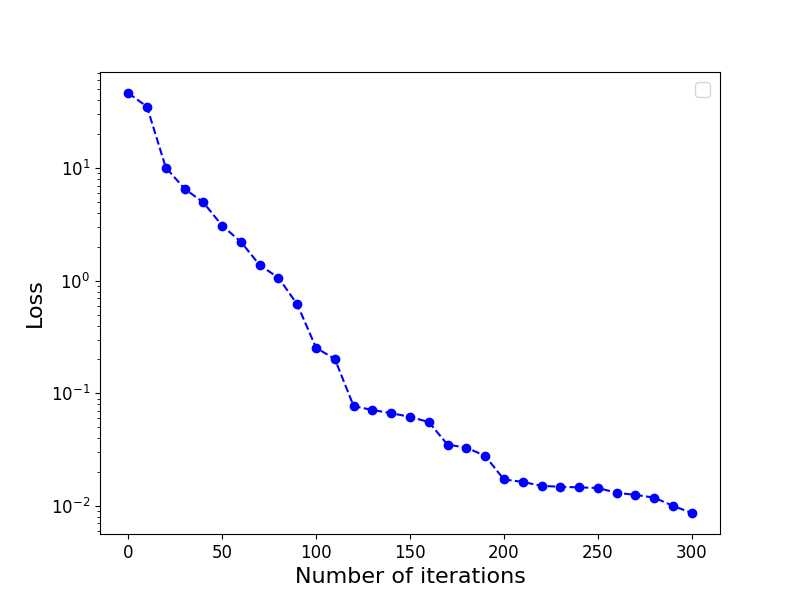

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [49]:
# Plot the loss
nit1 = 300
nit2 = 0
step = 10

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, nit1+1, step), loss_history[:int(nit1/step)+1], 'bo--', label="")
#plt.plot(np.arange(nit1, nit1 + nit2, step), loss_history[int(nit1/step)+1:], 'ro--', label='All coeffs')
#plt.plot(np.arange(nit1, nit1 + nit2 + 1, step), loss_history, 'ro--', label='All coeffs')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.legend()

<IPython.core.display.Javascript object>


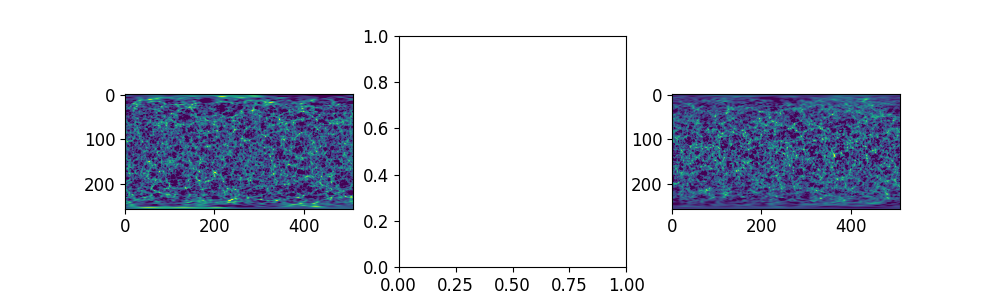

In [50]:
#mn, mx = np.nanmin(f_target), np.nanmax(f_target)
#mn, mx = -1, 3
#mn, mx = None, None
mn, mx = -1, 3


fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
ax1.imshow(np.real(f_target), vmax=mx, vmin=mn, cmap='viridis')
#ax2.imshow(np.real(f_start), vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

<IPython.core.display.Javascript object>


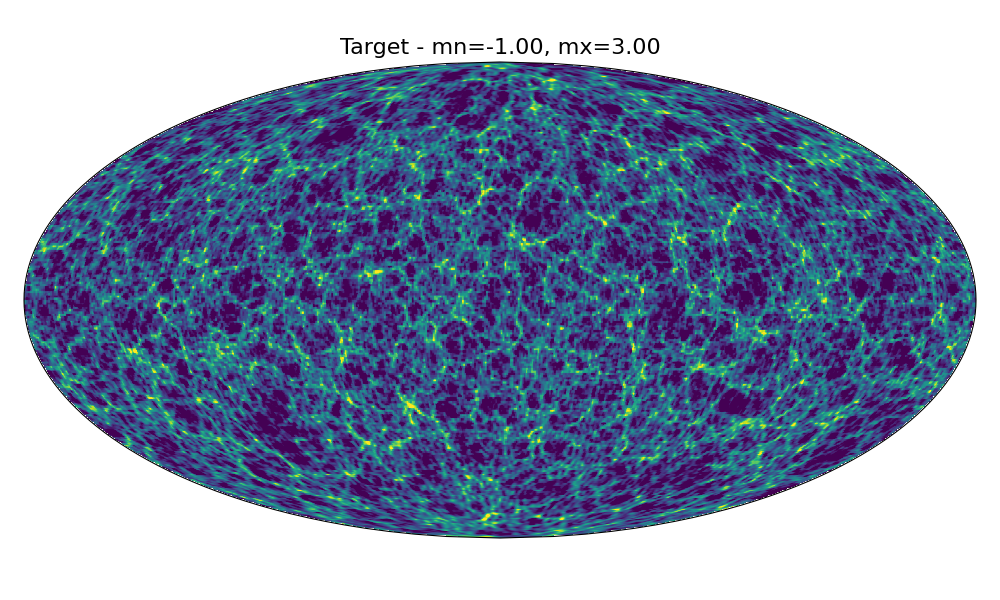

In [51]:
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, title=f'Target - {mn=:.2f}, {mx=:.2f}', figsize=(10, 6))

<IPython.core.display.Javascript object>


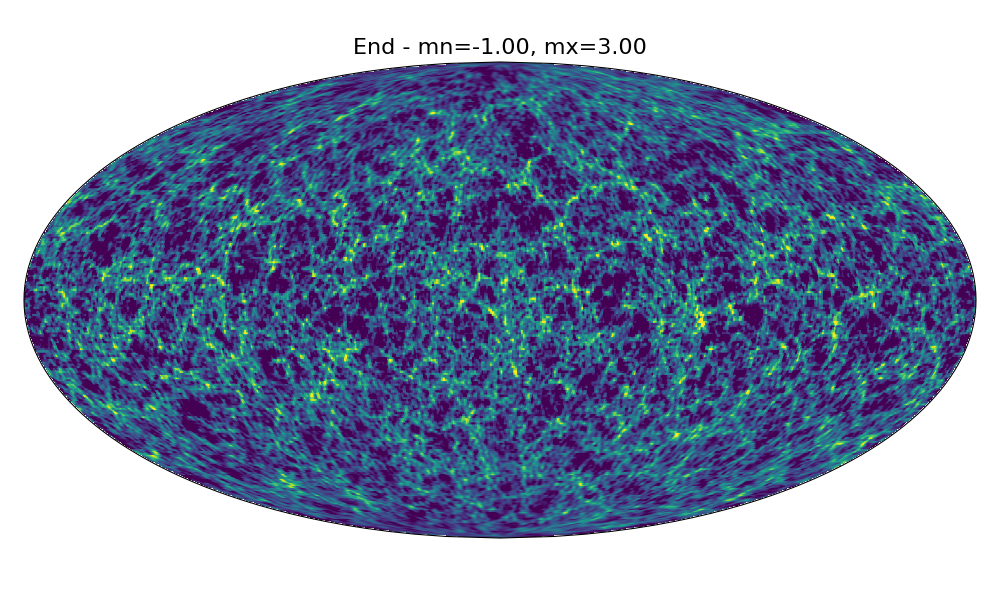

In [52]:
plot.plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, title=f'End - {mn=:.2f}, {mx=:.2f}', figsize=(10, 6))

<IPython.core.display.Javascript object>


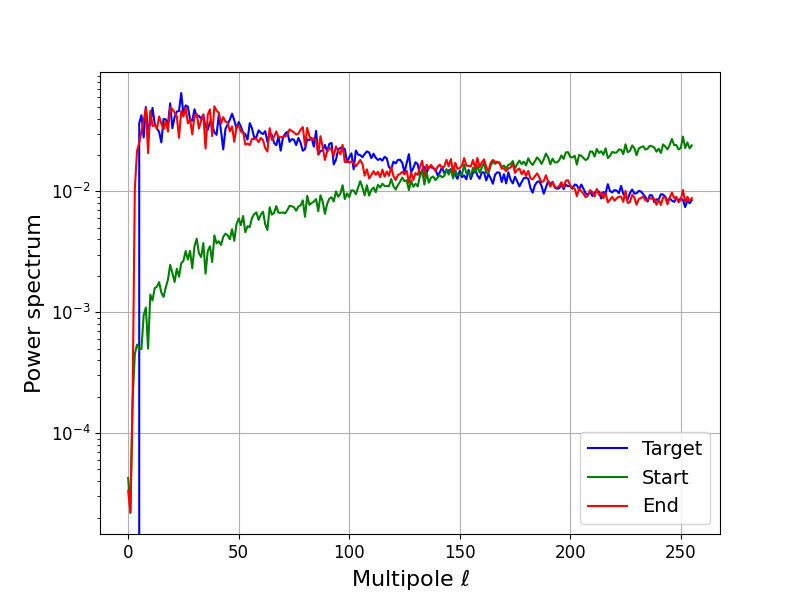

In [53]:
# Power spectrum
ps_target = sphlib.compute_ps(flm_target)
ps_start = sphlib.compute_ps(flm_start)
ps_end = sphlib.compute_ps(flm_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_start, 'g', label="Start")
plt.plot(ps_end, 'r', label="End")
plt.yscale("log")
#plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
#plt.xlim(2, 64)
#plt.ylim(1e-4, 1)
plt.legend()

<IPython.core.display.Javascript object>


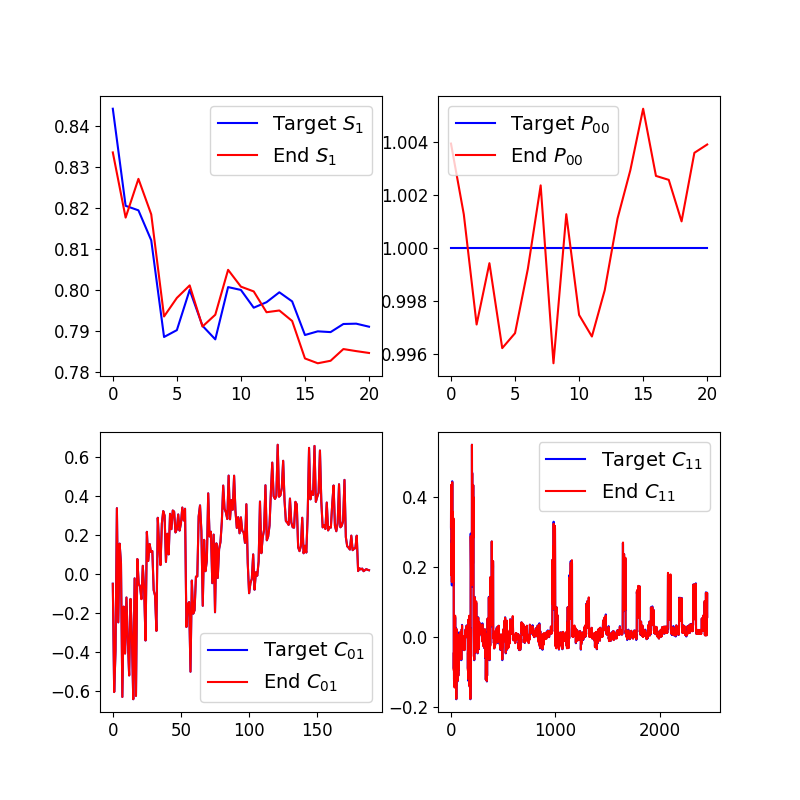

In [54]:
# Scatcov coeffs
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue')

#plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green')

plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red')